In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,color,feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk


nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data Exploration

In [3]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = '/content/drive/MyDrive/AiOG/IMDB Dataset.csv'

# Load the dataset into a Pandas DataFrame
dataset = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset to check its structure
print(dataset.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Data Cleaning

In [4]:
import re

# Function to remove HTML tags from a string
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_html_tags)
# Convert the 'text' column to lowercase
dataset['review'] = dataset['review'].str.lower()
# Function to remove punctuation and special characters from a string
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_punctuation)


Tokenizing

In [5]:
from nltk.tokenize import word_tokenize


# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)


# Apply the function to the 'text' column
dataset['tokens'] = dataset['review'].apply(tokenize_text)


from keras.preprocessing.text import Tokenizer


# Create a tokenizer and fit it on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'])


# Convert the text tokens to sequences of integers
dataset['sequences'] = tokenizer.texts_to_sequences(dataset['tokens'])


Label encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
dataset['label'] = label_encoder.fit_transform(dataset['sentiment'])

# Display the mapping of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'negative': 0, 'positive': 1}


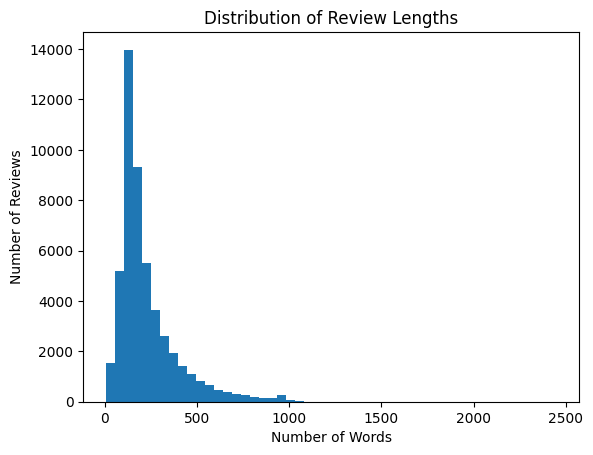

In [7]:
# Analyze the distribution of review lengths
review_lengths = dataset['review'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.hist(review_lengths, bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


Data Splitting and padding

In [8]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split

# Define the features (X) and labels (y)
X = dataset['review']
y = dataset['label']

# Split the data into training and temporary (validation + test) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Display the sizes of the resulting sets
print("Training set size:", len(X_train_temp))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Parameters
vocab_size = 1000
embedding_dim = 50  # can also use pre-trained embeddings like GloVe or Word2Vec


# Set sequence_length to 1000
sequence_length = 1000

# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_temp)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_temp)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=sequence_length, padding='post')


Training set size: 15000
Validation set size: 7000
Test set size: 28000


Model Compiliation, Traning and Testing

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train_pad, y_train_temp, epochs=10, validation_data=(X_val_pad, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          50000     
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 128)               6400128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

Plotting the learning curve

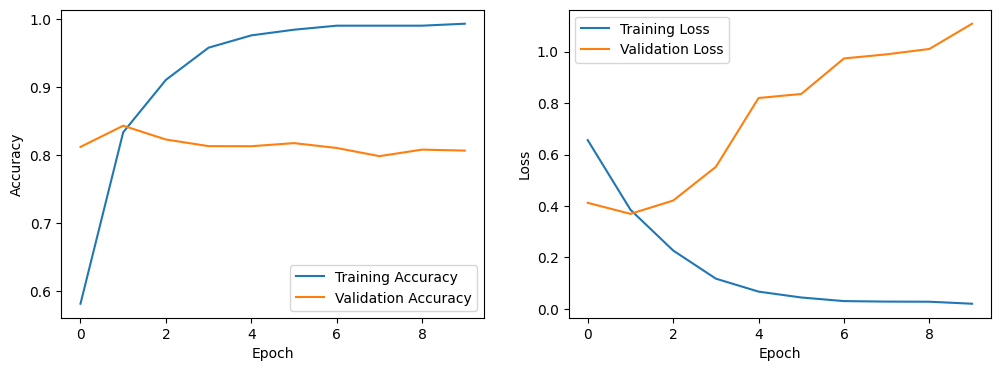

In [10]:
import matplotlib.pyplot as plt

# Access training history from the 'history' object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Confusion Matrix

875/875 [==============================] - 11s 12ms/step


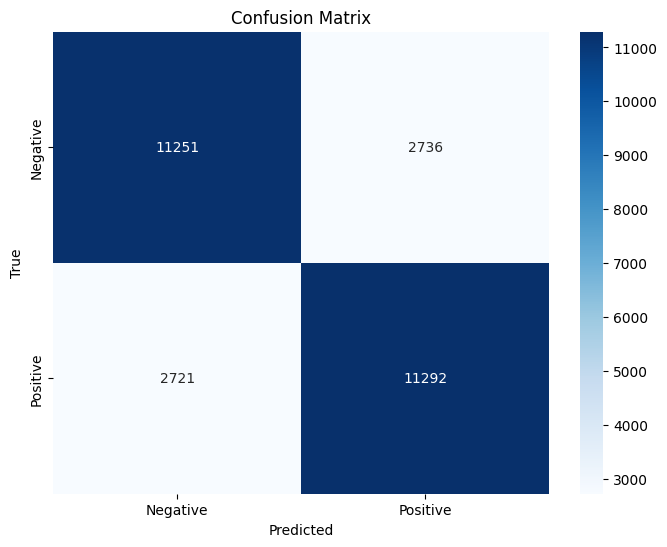

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gettting predictions on the test set
y_pred = model.predict(X_test_pad)

# Converting predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


875/875 [==============================] - 13s 15ms/step - loss: 1.1152 - accuracy: 0.8051
Test Loss: 1.1152
Test Accuracy: 0.8051


Classification Report

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on the test set
test_predictions = model.predict(X_test_pad)
# Convert predictions to binary values (0 or 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Calculate confusion matrix, precision, recall, and F1 score
conf_matrix = confusion_matrix(y_test, test_predictions_binary)
classification_rep = classification_report(y_test, test_predictions_binary)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


875/875 [==============================] - 17s 19ms/step
Confusion Matrix:
[[11251  2736]
 [ 2721 11292]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     13987
           1       0.80      0.81      0.81     14013

    accuracy                           0.81     28000
   macro avg       0.81      0.81      0.81     28000
weighted avg       0.81      0.81      0.81     28000



Dataset citation

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}